# Finalizing model 1 for price prediction

Import relevant libraries

In [3]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime, timedelta

from copy import deepcopy

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

### Import Train and Test Data and Prepare for Models

In [13]:
path = 'C:/mie1628_big_data/assignment_5/cloud_ml_proj/data/train_set_2018_01_01_01_2022_09_16_06.csv'
path_test = 'C:/mie1628_big_data/assignment_5/cloud_ml_proj/data/test_set_2022_09_16_07_2023_11_20_00.csv'

train_set = pd.read_csv(path, index_col=0)
train_set.index = pd.DatetimeIndex(train_set.index)
train_set = train_set.rename(columns={'Total Snow (cm)':'tot_snow'})

test_set = pd.read_csv(path_test, index_col=0)
test_set.index = pd.DatetimeIndex(test_set.index)
test_set = test_set.rename(columns={'Total Snow (cm)':'tot_snow'})

print(train_set.shape, test_set.shape)

(41262, 65) (10314, 65)


### Imputation
function imputes the data

In [16]:
from sklearn.impute import KNNImputer

In [17]:
def input_energyprice_data(data):
    """Imputting temp, CDD/HDD, precip, and wind data"""
    # Temperatures and HDD/CDD imputed using the median of the month
    data_c = data.copy()
    temp_fill_table = data_c.groupby('Month').median()[['max_t','min_t','mean_t','hdd','cdd']]
    for m in range(1,13):
        data_c.loc[data_c['Month'] == m] = data_c.loc[data_c['Month'] == m].fillna({'max_t': temp_fill_table.loc[m,'max_t'],
                                                                                    'min_t': temp_fill_table.loc[m,'min_t'],
                                                                                    'hdd': temp_fill_table.loc[m,'hdd'],
                                                                                    'cdd': temp_fill_table.loc[m,'cdd'],
                                                                                    'mean_t': temp_fill_table.loc[m,'mean_t']})
        
    # precipitation imputed assuming there is no precip on those days (analysis shows nothing particularly special; probably scheduled maintenance)
    data_c[['tot_rain','tot_snow','tot_precip']] = data_c[['tot_rain','tot_snow','tot_precip']].fillna(0)

    # there is no simple gust dir and speed imputation: use K-NN impute, take sqrt(N) for val of K
    knn_impute = KNNImputer(n_neighbors=int(np.sqrt(data_c.shape[0])))
    data_c_knn = knn_impute.fit_transform(data_c)
    data_c_knn = pd.DataFrame(columns=data_c.columns, index=data_c.index, data=data_c_knn)
        

    return data_c_knn

In [18]:
train_set_imputed = input_energyprice_data(train_set)
test_set_imputed = input_energyprice_data(test_set)

In [21]:
train_set_imputed.columns

Index(['hourly_price', 'or_10s', 'or_10ns', 'or_30', 'Hour', 'market_demand',
       'ont_demand', 'Imp', 'Exp', 'Flow', 'Imp.1', 'Exp.1', 'Flow.1', 'Imp.2',
       'Exp.2', 'Flow.2', 'Imp.3', 'Exp.3', 'Flow.3', 'Imp.4', 'Exp.4',
       'Flow.4', 'Imp.5', 'Exp.5', 'Flow.5', 'Imp.6', 'Exp.6', 'Flow.6',
       'Imp.7', 'Exp.7', 'Flow.7', 'Imp.8', 'Exp.8', 'Flow.8', 'Imp.9',
       'Exp.9', 'Flow.9', 'Imp.10', 'Exp.10', 'Flow.10', 'Imp.11', 'Exp.11',
       'Flow.11', 'Imp.12', 'Exp.12', 'Flow.12', 'Imp.13', 'Exp.13', 'Flow.13',
       'Imp.14', 'Exp.14', 'Flow.14', 'Year', 'Month', 'Day', 'max_t', 'min_t',
       'mean_t', 'hdd', 'cdd', 'tot_rain', 'tot_snow', 'tot_precip',
       'gust_dir', 'gust_speed'],
      dtype='object')

### Feature Engineering
function develops relevant features

In [316]:
def feature_eng(dataset, target_col='market_demand', lag_var ='market_demand'):
    """
    Feature takes in dataset and creates features for regression.
    """

    # demand from 24 hours ago
    demand_lag = dataset[lag_var].shift(24)
    demand_lag.name = 'lag_24'

    # a weighted moving average of the demand from 2, 3, and 4 days ago
    lag_groups = [#[23,24,25],
                  [47,48,49],[71,72,73],[95,96,97]]
    # this method works better but drops more data
    demand_lag_mean_7_days = []
    for l in lag_groups:
        demand_lag_n = pd.concat([dataset[lag_var].shift(i) for i in l], axis=1).mean(axis=1)
        demand_lag_mean_7_days.append(demand_lag_n)
    demand_lag_mean_7_days= pd.concat(demand_lag_mean_7_days, axis=1)
    demand_lag_mean_7_days.columns = ['sd_lag'+str(i) for i in range(2,5)]

    # the cooling degree days from the previous day
    cooling_days = pd.DataFrame(dataset['cdd'].shift(24))
    cooling_days = cooling_days.rename(columns={0:'cdd_24'})

    # the gust direction the previous day and snowfall
    gust_lag = dataset['gust_dir'].shift(24)
    snow = dataset['tot_snow'].shift(24)

    # the month of the year
    month_feat = dataset[['Month']]

    # weekend
    weekend = pd.DataFrame(dataset.index.dayofweek > 4, index=dataset.index)
    weekend = weekend.rename(columns={0:'weekend'})

    # combine all and split for training and testing
    features = pd.concat([dataset[target_col],
                          demand_lag,
                          demand_lag_mean_7_days,
                          cooling_days,
                          gust_lag,
                          snow,
                          month_feat,
                          weekend,
                          ], axis=1).dropna()
    
    target = features[target_col]
    features = features.drop(target_col, axis=1)

    return (features, target)

In [317]:
X_train = feature_eng(train_set_imputed)[0]
y_train = feature_eng(train_set_imputed)[1]

In [318]:
X_test = feature_eng(test_set_imputed)[0]
y_test = feature_eng(test_set_imputed)[1]

## Fit First Model
fit a linear regression to predict demand a day ahead

In [272]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [319]:
# init
reg_model = linear_model.Lasso(alpha=10)

# fit
print(X_train.shape)
print(y_train.shape)
print(X_train.columns)
reg_model.fit(X_train, np.array(y_train).squeeze())

# predict
y_pred = reg_model.predict(X_test)

# res
print("Coefficients: \n", reg_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(np.array(y_test), y_pred))
# The coefficient of determination
print("Coefficient of determination: %.2f" % r2_score(np.array(y_test), y_pred))

(41167, 9)
(41167,)
Index(['lag_24', 'sd_lag2', 'sd_lag3', 'sd_lag4', 'cdd', 'gust_dir',
       'tot_snow', 'Month', 'weekend'],
      dtype='object')
Coefficients: 
 [ 7.32397267e-01 -8.00824755e-02  1.22921696e-01  1.40183005e-01
  3.30694100e+01 -2.61279988e+00  1.71341355e+01 -8.61530172e+00
 -7.51441304e+02]
Mean squared error: 794481.04
Coefficient of determination: 0.82


Plot some results:

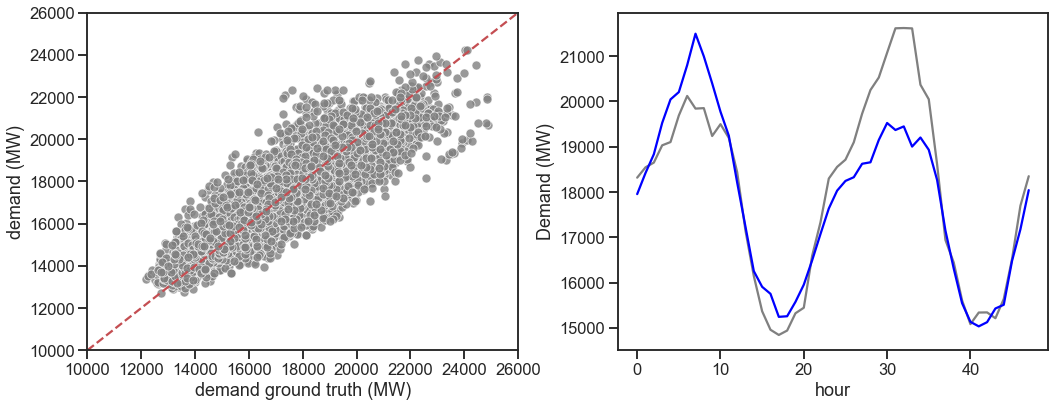

In [75]:
y_test_plot = y_test
y_pred_plot = y_pred

fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(x=y_test_plot, y=y_pred_plot, ax=ax[0], alpha=0.8, color='grey')

start = 7900
end = 7948
sns.lineplot(x=np.arange(end-start), y=y_test_plot[start:end], ax=ax[1],
             color='grey')
sns.lineplot(x=np.arange(end-start), y=y_pred_plot[start:end], ax=ax[1],
             color='blue')


ax[0].set_xlabel('demand ground truth (MW)')
ax[0].set_ylabel('demand (MW)')
ax[0].set_xlim([10000,26000])
ax[0].set_ylim([10000,26000])
sns.lineplot(ax=ax[0], x=np.arange(10000,26000), y=np.arange(10000,26000), linestyle='--', color='r')

ax[1].set_xlabel('hour')
ax[1].set_ylabel('Demand (MW)')

plt.tight_layout()

In [342]:
import random
import matplotlib.gridspec as gridspec

In [320]:
def rand_plottr(y_test, y_pred, colo='blue', title=''):
    # Create a figure and a gridspec layout
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 1])
    ax1 = plt.subplot(gs[0:2, :])
    ax2 = plt.subplot(gs[2, 0])
    ax3 = plt.subplot(gs[2, 1])
    ax4 = plt.subplot(gs[2, 2])
    ax5 = plt.subplot(gs[3, 0])
    ax6 = plt.subplot(gs[3, 1])
    ax7 = plt.subplot(gs[3, 2])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

    #sns.scatterplot(x=y_test, y=y_pred, ax=ax1, alpha=0.8, color='grey')
    sns.histplot(x=y_test, y=y_pred, ax=ax1, 
                 cmap='RdPu_r',#'YlGnBu_r',#'RdPu_r', 
                 cbar=True, cbar_kws={"shrink": 0.8, "location":"right"})
    ax1.set_xlabel('demand ground truth (MW)')
    ax1.set_ylabel('demand pred (MW)')
    ax1.set_xlim([10000,26000])
    ax1.set_ylim([10000,26000])
    sns.lineplot(ax=ax1, x=np.arange(10000,26000), y=np.arange(10000,26000), linestyle='--', color='r')


    for i, a in enumerate(axes[1:]):
        start = random.randint(0, len(y_pred)-48)
        end = start+48
        sns.lineplot(x=np.arange(end-start), y=y_test[start:end], ax=a,
                color='grey')
        sns.lineplot(x=np.arange(end-start), y=y_pred[start:end], ax=a,
                    color=colo)
        
        a.set_ylabel('')
        a.set_xlabel('')
        a.set_title('48hr interval')
        if i in [0,3]:
            a.set_ylabel('Demand (MW)')
        if i in [3,4,5]:    
            a.set_xlabel('hour')

    # Adjust layout for better spacing
    plt.suptitle(title)
    plt.tight_layout()

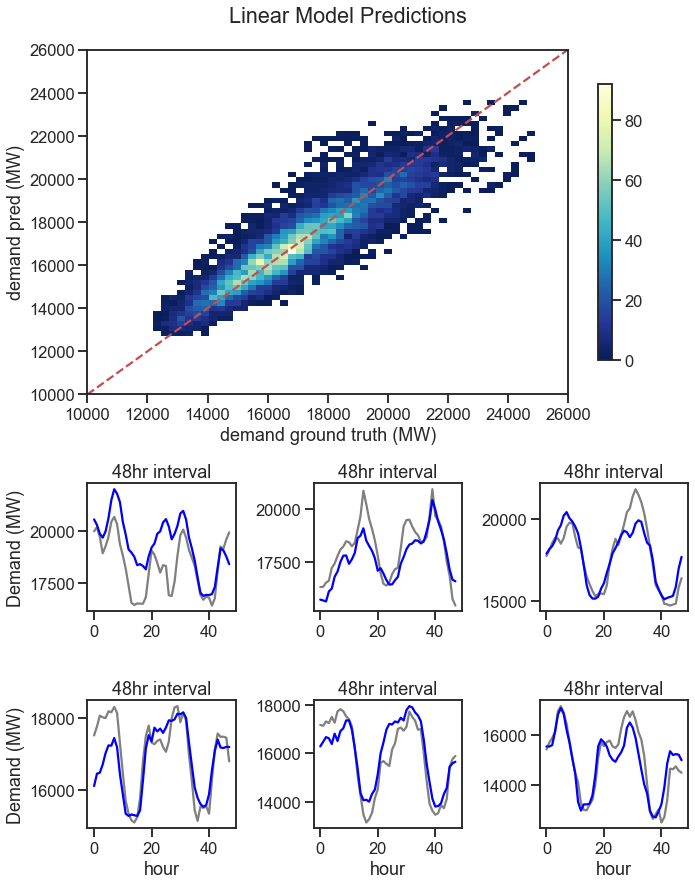

In [278]:
rand_plottr(y_test, y_pred, title='Linear Model Predictions')

## Train Second Model
try using a more powerful model than liear regression to see if it performs better

In [134]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [321]:
# init
boost_model = GradientBoostingRegressor(min_samples_split=5, 
                                        min_samples_leaf=5,
                                        max_features=5)

# fit
print(X_train.shape)
print(y_train.shape)
print(X_train.columns)
boost_model.fit(X_train, np.array(y_train).squeeze())

# predict
y_pred2 = boost_model.predict(X_test)

# res
#print("Coefficients: \n", boost_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(np.array(y_test), y_pred2))
# The coefficient of determination
print("Coefficient of determination: %.2f" % r2_score(np.array(y_test), y_pred2))

(41167, 9)
(41167,)
Index(['lag_24', 'sd_lag2', 'sd_lag3', 'sd_lag4', 'cdd', 'gust_dir',
       'tot_snow', 'Month', 'weekend'],
      dtype='object')
Mean squared error: 767176.01
Coefficient of determination: 0.83


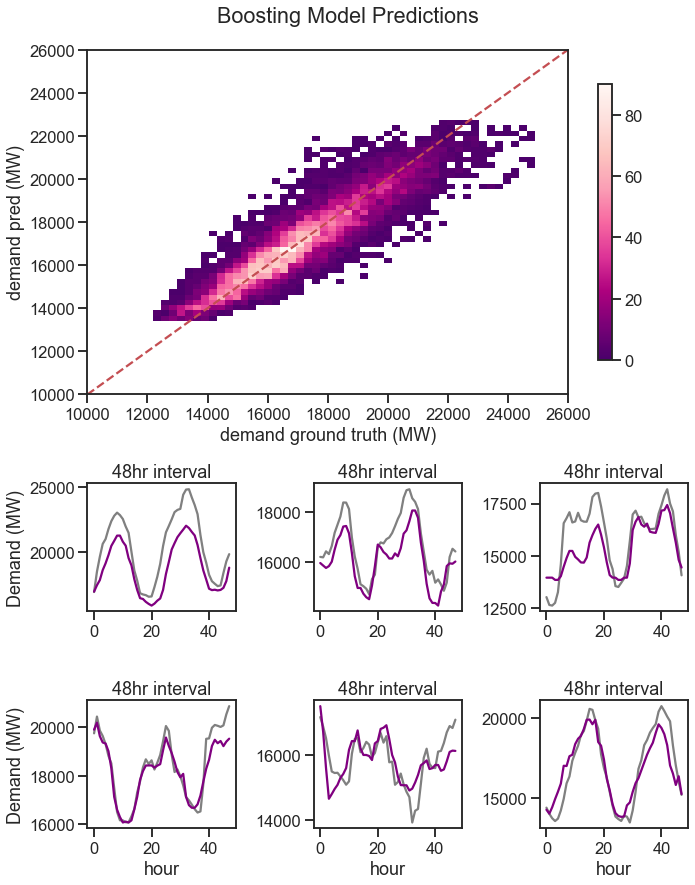

In [322]:
rand_plottr(y_test, y_pred2, colo='purple', title='Boosting Model Predictions')

-------------------------------------
## Predicting Price
just for fun, can we do better than the price predispatch?

In [324]:
X_train = feature_eng(train_set_imputed, target_col='hourly_price', lag_var='hourly_price')[0]
y_train = feature_eng(train_set_imputed, target_col='hourly_price', lag_var='hourly_price')[1]
X_test = feature_eng(test_set_imputed, target_col='hourly_price', lag_var='hourly_price')[0]
y_test = feature_eng(test_set_imputed, target_col='hourly_price', lag_var='hourly_price')[1]

In [347]:
# init
boost_model = GradientBoostingRegressor(min_samples_split=5, 
                                        min_samples_leaf=5,
                                        max_features=5)

# fit
print(X_train.shape)
print(y_train.shape)
print(X_train.columns)
boost_model.fit(X_train, np.array(y_train).squeeze())

# predict
y_pred2 = boost_model.predict(X_test)

# res
#print("Coefficients: \n", boost_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(np.array(y_test), y_pred2))
# The coefficient of determination
print("Coefficient of determination: %.2f" % r2_score(np.array(y_test), y_pred2))

(41167, 9)
(41167,)
Index(['lag_24', 'sd_lag2', 'sd_lag3', 'sd_lag4', 'cdd', 'gust_dir',
       'tot_snow', 'Month', 'weekend'],
      dtype='object')
Mean squared error: 520.57
Coefficient of determination: 0.20


import Ontario price pre-dispatch and compare the MSE

In [326]:
price = []
for x in range(2018,2024):
    #print(x)
    
    price_x = pd.read_csv('C:/mie1628_big_data/assignment_5/cloud_ml_proj/data/price_data_y/PUB_PriceHOEPPredispOR_{}.csv'.format(x), header=3, index_col=0)   
    price_x.index = pd.DatetimeIndex(price_x.index) + pd.to_timedelta(price_x['Hour'], unit='h')
    price.append(price_x)

price_t = pd.concat(price)
print(price_t.shape)
price_t.head()

(51576, 8)


,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
2018-01-01 01:00:00,1,51.29,40.62,35.50,40.32,0.20,0.20,0.19
2018-01-01 02:00:00,2,43.59,40.93,40.57,30.22,0.20,0.20,0.20
2018-01-01 03:00:00,3,93.60,49.84,45.30,40.20,0.25,0.25,0.22
2018-01-01 04:00:00,4,54.78,55.60,40.04,45.30,0.20,0.20,0.20
2018-01-01 05:00:00,5,14.35,40.04,34.80,47.47,0.20,0.20,0.20


In [340]:
price_compare = price_t[datetime(2022,9,20,6):datetime(2023,11,20,0)].dropna()
price_compare
# INFORMATION LEAKAGE:
print("Mean squared error: %.2f" % mean_squared_error(price_compare['HOEP'], price_compare['Hour 3 Predispatch']))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(price_compare['HOEP'], price_compare['Hour 3 Predispatch']))

Mean squared error: 805.68
Coefficient of determination: -0.24


In [359]:
def rand_plottr_price(y_test, y_pred, colo='blue', title=''):
    # Create a figure and a gridspec layout
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 1])
    ax1 = plt.subplot(gs[0:2, :])
    ax2 = plt.subplot(gs[2, 0])
    ax3 = plt.subplot(gs[2, 1])
    ax4 = plt.subplot(gs[2, 2])
    ax5 = plt.subplot(gs[3, 0])
    ax6 = plt.subplot(gs[3, 1])
    ax7 = plt.subplot(gs[3, 2])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

    #sns.scatterplot(x=y_test, y=y_pred, ax=ax1, alpha=0.8, color='grey')
    sns.histplot(x=y_test, y=y_pred, ax=ax1, 
                 cmap='RdPu_r',#'YlGnBu_r',#'RdPu_r', 
                 cbar=True, cbar_kws={"shrink": 0.8, "location":"right"})
    ax1.set_xlabel('demand ground truth (MW)')
    ax1.set_ylabel('demand pred (MW)')
    ax1.set_xlim([10000,26000])
    ax1.set_ylim([10000,26000])
    sns.lineplot(ax=ax1, x=np.arange(10000,26000), y=np.arange(10000,26000), linestyle='--', color='r')


    for i, a in enumerate(axes[1:]):
        start = random.randint(0, len(y_pred)-48)
        end = start+48
        sns.lineplot(x=np.arange(end-start), y=y_test[start:end], ax=a,
                color='grey')
        sns.lineplot(x=np.arange(end-start), y=y_pred[start:end], ax=a,
                    color=colo)
        sns.lineplot(x=np.arange(end-start), y=price_compare['Hour 1 Predispatch'][start:end], ax=a,
            color='lightblue')
        
        a.set_ylabel('')
        a.set_xlabel('')
        a.set_title('48hr interval')
        if i in [0,3]:
            a.set_ylabel('Demand (MW)')
        if i in [3,4,5]:    
            a.set_xlabel('hour')

    # Adjust layout for better spacing
    plt.suptitle(title)
    plt.tight_layout()

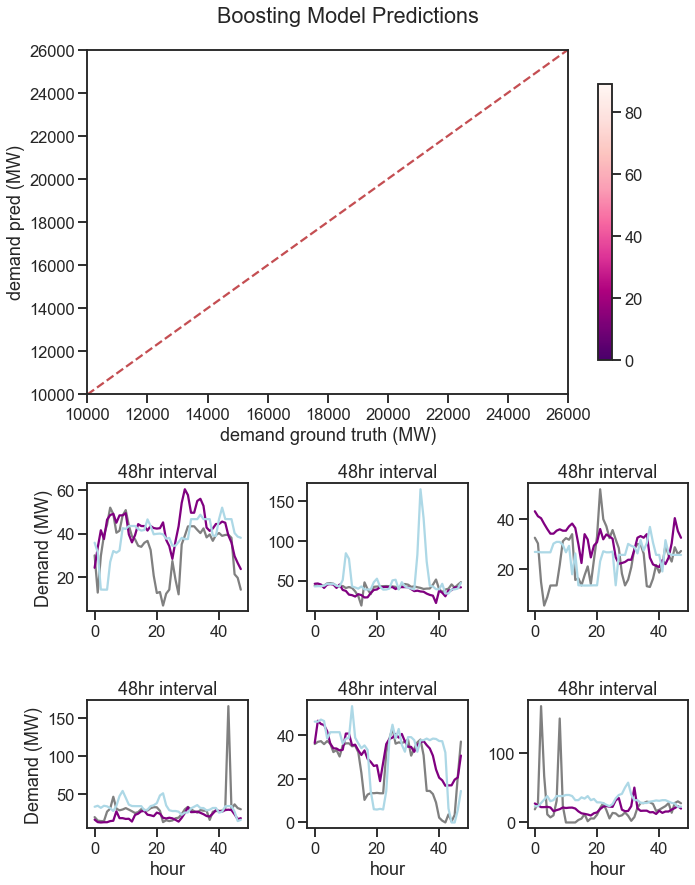

In [366]:
rand_plottr_price(y_test, y_pred2, colo='purple', title='Boosting Model Predictions')